# Source and description

<span style="color:green">Full link or name of the provider: </span> https://www.investopedia.com/inflation-rate-by-year-7253832 \
<span style="color:green">Series code: </span> inflation-rate-by-year-7253832 \
<span style="color:green">Date of access: </span>  Oct. 10, 2023 \
<span style="color:green">Description: </span> U.S. Inflation Rate by Year: 1929–2023.


In [132]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore") 
from sklearn.metrics import mean_squared_error

In [133]:
# Load data
df = pd.read_excel('data_khanova.xlsx')
df = df[["Year","Inflation rate YOY"]]
df.columns = ['date', 'y']
df["y"] = df.y.str.replace("%","")
df["y"] = df["y"].astype("float")

##### BONUS points: 
(a) Clean the data of outliers or breaks before point 1. You can be as creative as you wish but support your choice with arguments.

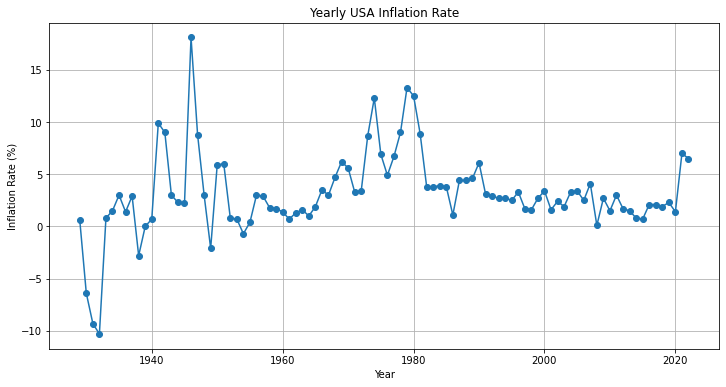

In [134]:
# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['y'], marker='o')
plt.title('Yearly USA Inflation Rate')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.grid(True)
plt.show()

Visual inspection to detect and potentially remove outliers. In the dataset, we can see some extreme values (e.g., 1940-1946 and 1974,1979, 2021) that might be considered outliers or due to specific events (e.g., post-war recovery or covid crisis). We will estimate the model using data from the 1952nd and excluding the post-Covid surge in inflation.

In [135]:
df = df[23:91]
df.reset_index(drop=True ,inplace = True)

#### POINT 1: 
Decide and describe whether the series is stationary or not. Support your argument with ACF and PACF functions, as well as statistical tests. Explain which transformation you will use to make the series stationary and ready for modelling.

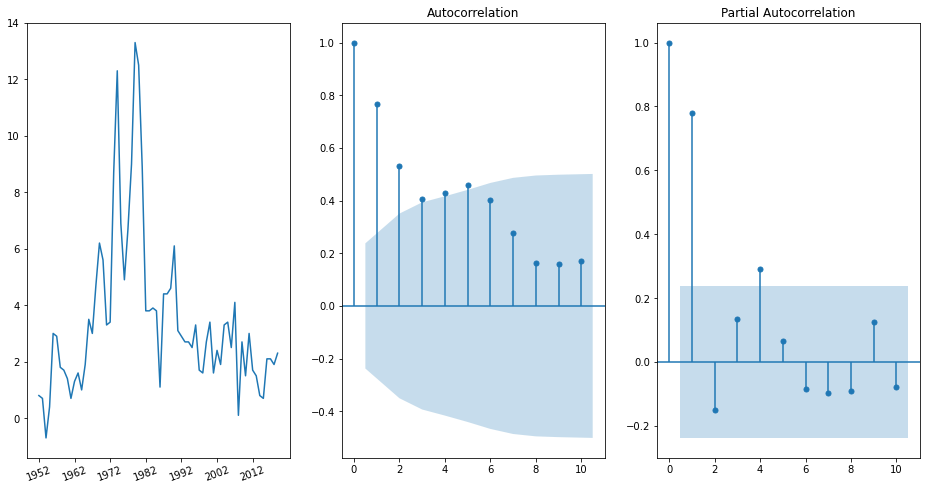

In [136]:
# plots 
fig, axs = plt.subplots(1, 3,figsize=(16,8))
axs[0].plot(df.y)
axs[0].set_xticks(np.arange(0,len(df.y),10))                                                       # display every 10-th tick
axs[0].set_xticklabels(df.date[np.arange(0,len(df.y),10)],rotation=20);                            # label ticks
sm.graphics.tsa.plot_acf(df.y, lags=10, ax=axs[1]);
sm.graphics.tsa.plot_pacf(df.y, lags=10, ax=axs[2]);

In [137]:
# test for stationarity
# ADF test
print("Results of Dickey-Fuller Test:")
res = sm.tsa.stattools.adfuller(df.y,maxlag=5,regression='c',autolag='AIC')
print(f"Test Statistic:{res[0]}")
print(f"p-value:{res[1]}")
print(f"#Lags Used:{res[2]}")
print(f"#Observations Used:{res[3]}")
p_value = res[1]
# KPSS test 
# In KPSS-test: 𝐻0:𝑡𝑟𝑒𝑛𝑑 − 𝑠𝑡𝑎𝑡𝑖𝑜𝑛𝑎𝑟𝑦

print("Results of KPSS Test:")
res = sm.tsa.stattools.kpss(df.y,regression='c',nlags='auto')
print(f"Test Statistic:{res[0]}")
print(f"p-value:{res[1]}")
print("-----------------------------------")

if p_value <= 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary.")

Results of Dickey-Fuller Test:
Test Statistic:-1.9418827310615354
p-value:0.3126217655863798
#Lags Used:3
#Observations Used:64
Results of KPSS Test:
Test Statistic:0.2702856296492651
p-value:0.1
-----------------------------------
The data is non-stationary.


Based on the ACF and PACF plots and the Dickey-Fuller test result, if the series is not stationary, we can apply first-order differencing to make it stationary.

In [138]:
df['y_diff'] = df['y'] - df['y'].shift(1)
df = df.dropna()  # Remove the first row with NaN
df.reset_index(drop=True ,inplace = True)

res = sm.tsa.stattools.adfuller(df.y_diff,maxlag=5,regression='c',autolag='AIC')
print(f"Test Statistic:{res[0]}")
print(f"p-value:{res[1]}")
print(f"#Lags Used:{res[2]}")
print(f"#Observations Used:{res[3]}")
p_value = res[1]
# KPSS test 
print("Results of KPSS Test:")
res = sm.tsa.stattools.kpss(df.y_diff,regression='c',nlags='auto')
print(f"Test Statistic:{res[0]}")
print(f"p-value:{res[1]}")
print("-----------------------------------")

if p_value <= 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary.")

Test Statistic:-7.473078042822203
p-value:4.9952346092178775e-11
#Lags Used:2
#Observations Used:64
Results of KPSS Test:
Test Statistic:0.11481135059413196
p-value:0.1
-----------------------------------
The data is stationary.


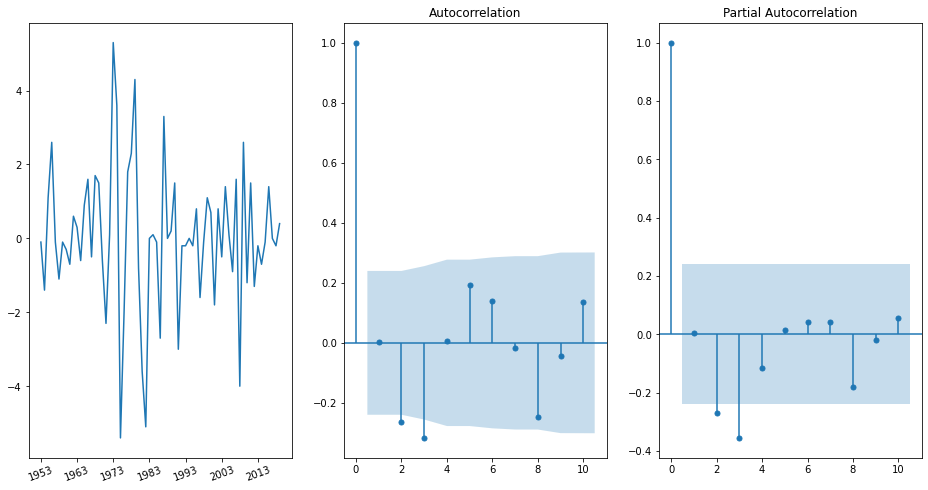

In [139]:
fig, axs = plt.subplots(1, 3,figsize=(16,8))
axs[0].plot(df.y_diff)
axs[0].set_xticks(np.arange(0,len(df.y_diff),10))                                                       # display every 10-th tick
axs[0].set_xticklabels(df.date[np.arange(0,len(df.y_diff),10)],rotation=20);                            # label ticks
sm.graphics.tsa.plot_acf(df.y_diff, lags=10, ax=axs[1]);
sm.graphics.tsa.plot_pacf(df.y_diff, lags=10, ax=axs[2]);

DECISION RULE: If p-value is < than desired significance level (1%,5% or 10%) we reject the null hypothesis.


The KPSS test has the null hypothesis that the series is stationary around a deterministic trend. In this case, the p-value is greater than 0.05, which suggests that we fail to reject the null hypothesis. 

In summary, the Dickey-Fuller test suggests that the series is stationary, while the KPSS test is inconclusive regarding stationarity.

#### POINT 2: 
Take the stationary series from point 1, use the first 80% of the sample for estimation, and select an appropriate ARIMA model. Justify your choice by means of tests and selection criteria.

In [140]:
# Define the split point (80% for estimation)
split_point = int(0.8 * len(df))
train_data = df['y_diff'][:split_point]
validation_data = df['y_diff'][split_point:]

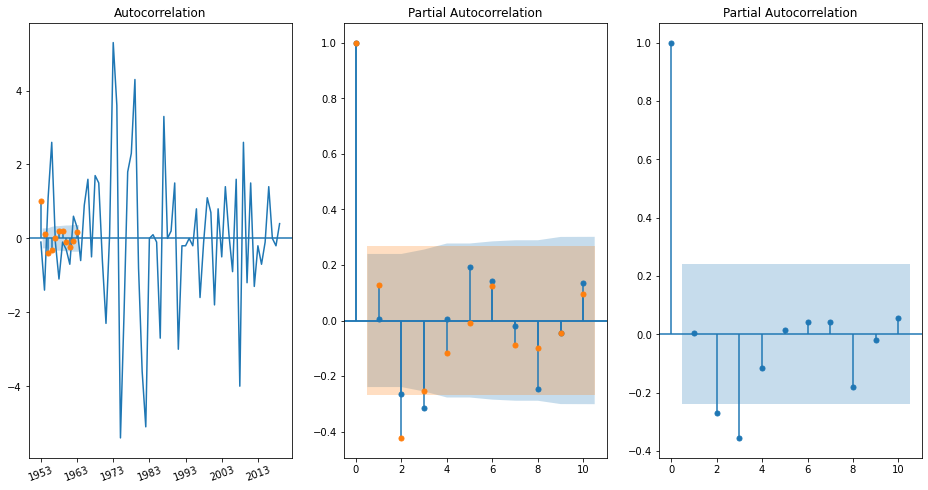

In [141]:
# ACF and PACF plots
# PART 3 Inspect AC and PAC function and select the number of AR and MA lags. 
#fig, axs = plt.subplots(1, 2,figsize=(12,10))
sm.graphics.tsa.plot_acf(train_data, lags=10, ax=axs[0])
sm.graphics.tsa.plot_pacf(train_data, lags=10, ax=axs[1])

In [142]:
# PART 3 Decide on the appropriate ARIMA(p,d,q) model
import warnings
warnings.filterwarnings("ignore") 
 
# estimate ICs
IC = sm.tsa.stattools.arma_order_select_ic(train_data, max_ar=4, max_ma=4, ic=['aic','bic','hqic'], trend='c')
# display optimal lags
print(f"min AIC at (p,q): {IC.aic_min_order}")
print(f"min BIC at (p,q): {IC.bic_min_order}")
print(f"min HQIC at (p,q): {IC.hqic_min_order}")

min AIC at (p,q): (3, 0)
min BIC at (p,q): (2, 0)
min HQIC at (p,q): (3, 0)


In [143]:
# PART 4 Estimate the true model
mod = sm.tsa.arima.ARIMA(train_data, order=(3, 0, 0), trend='c', validate_specification=True)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 y_diff   No. Observations:                   53
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -104.936
Date:                Mon, 30 Oct 2023   AIC                            219.872
Time:                        20:30:20   BIC                            229.723
Sample:                             0   HQIC                           223.660
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0490      0.163      0.300      0.764      -0.271       0.369
ar.L1          0.0762      0.151      0.505      0.614      -0.220       0.372
ar.L2         -0.3559      0.123     -2.884      0.0

Ljung-Box and Box-Pierce for residual autocorrelation


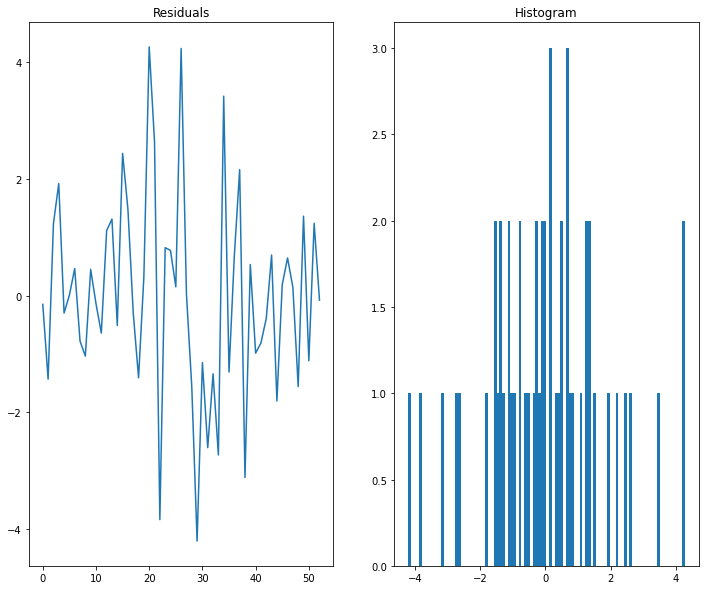

In [144]:
# Plot residuals
fig, axs = plt.subplots(1, 2,figsize=(12,10))
axs[0].plot(results.resid)
axs[0].set_title("Residuals")
axs[1].hist(results.resid,bins=100)
axs[1].set_title("Histogram")

# Test for whitness of residuals 
print("Ljung-Box and Box-Pierce for residual autocorrelation")
res_lb = sm.stats.diagnostic.acorr_ljungbox(results.resid, lags=10, boxpierce=True,model_df=0+0)

#### POINT 3: 
Use the model from point 2 and perform one-step-ahead forecasts, with expanding window, for your series for the remaining 20% of the sample (you can refer to the code from “Ex_multi_TS_real_data.ipynb”). Plot the forecasts and the true values. Also, report the RMSE of the forecasts. You will later compare this RMSE to the RMSE obtained in a VAR and NN model. For example,
if you have 100 observations, the 1st one-step-ahead forecast: Estimate the model on T = 1…80 and forecast the value for T=81. The 2nd one-step-ahead forecast: Estimate the model on T = 1…81 and forecast T=82, and so on.


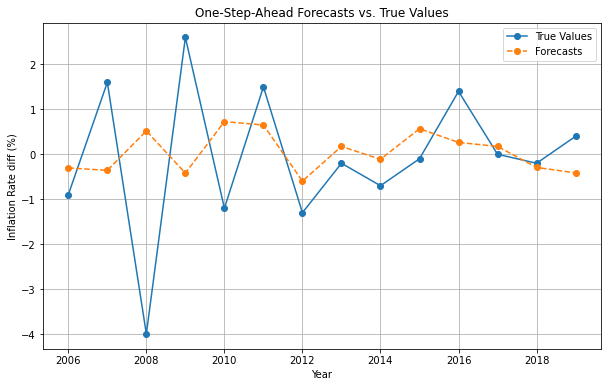

Root Mean Squared Error (RMSE): 1.72


In [154]:
# POINT 3: Perform One-Step-Ahead Forecasts with Expanding Window
# Forecast for the remaining 20% of the sample
forecasted_values = []

for i in range(len(validation_data)):
    window = df['y_diff'][:split_point + i]
    model = ARIMA(window, order=(3, 0, 0))
    results = model.fit(disp=0)
    forecast = results.forecast(steps=1)[0]
    forecasted_values.append(forecast)

# Plot the forecasts and true values
plt.figure(figsize=(10, 6))
plt.plot(df['date'][split_point:], validation_data, label='True Values', marker='o', linestyle='-')
plt.plot(df['date'][split_point:], forecasted_values, label='Forecasts', marker='o', linestyle='--')
plt.title('One-Step-Ahead Forecasts vs. True Values')
plt.xlabel('Year')
plt.ylabel('Inflation Rate diff (%)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(validation_data, forecasted_values))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

##### BONUS points: 
(b) Explain what is the consequence of estimating an ARIMA model on a non-stationary series. 

Estimating an ARIMA model on non-stationary data may require differencing the data to achieve stationarity. Non-stationary data can have unpredictable trends and irregularities. Estimating an ARIMA model without first differencing the data may lead to inaccurate forecasts. Standard model diagnostics, such as checking for autocorrelation in residuals or examining information criteria (AIC, BIC), may not be valid on non-stationary data.